In [62]:
import numpy as np
from scipy import ndimage
from astropy.io import fits
import matplotlib.pyplot as plt
import l2_processor.aspiics_detector  as det
import l2_processor.aspiics_optics    as optics
import l2_processor.aspiics_get_opse  as opse
import l2_processor.parameters        as par
import os

def read_fits_image_array(filename):
    """See https://docs.astropy.org/en/stable/io/fits/ for more info"""
    with fits.open(filename, do_not_scale_image_data=True) as hdul:             
       imagedata = hdul[0].data
       header    = hdul[0].header
    return imagedata, header

def write_fits(imagedata, inputfile, outputfile):
    with fits.open(inputfile) as hdul:
       hdul[0].data = imagedata
       hdul.writeto(outputfile)

# *************** Parsing arguments *****************

# argparse placeholder
class args:
    file = 'testfile.fits'
    diff = 'None'
    save_diff = False
    cal = 'l2_config.json'
    filter = 'None'
    outdir = './calibration-data/calibration_data_optimized/'
    mark_IO = False
    mark_suncenter = False

#outputdir = './output/'
outputdir = args.outdir
mark_io   = args.mark_IO
mark_sun  = args.mark_suncenter



In [60]:
# ***************** Input image *******************

filename='./calibration-data/calibration_data_20100101000000_20241205000000/flatfield_WB.fits'
#filename = sys.argv[1]
# filename=args.file


Im, header = read_fits_image_array(filename)
print("%*******************************************************************************")
print("% Flat banding correction "+os.path.basename(filename))
print(f"% Header info: \n {repr(header)}") 


%*******************************************************************************
% Flat banding correction flatfield_WB.fits
% Header info: 
 SIMPLE  =                    T / Written by IDL:  Wed Aug 31 16:17:41 2022      
BITPIX  =                  -32 / Number of bits per data pixel                  
NAXIS   =                    2 / Number of data axes                            
NAXIS1  =                 2048 /                                                
NAXIS2  =                 2048 /                                                
FILTER  = 'Wideband'           /                                                
INSTRUME= 'Flat field for Wideband' / On-ground Ak campaign                     
ORIGIN  = 'WB files'           / Wrong filenames in on-ground campaign          
X_IO    =              1003.42 / [1..2048] measured in on-ground data and fine- 
Y_IO    =              1027.80 / [1..2048] tuned to have symmetrical zone       
DATE    = '2022-08-31'         / Creation UTC (C

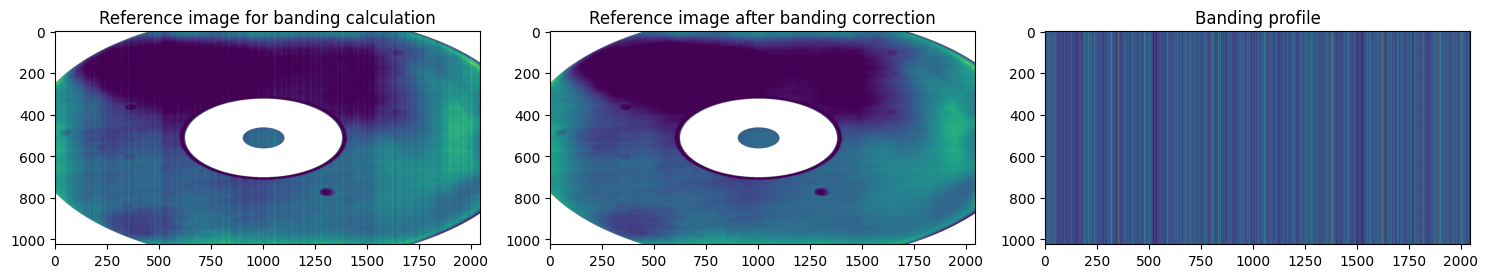

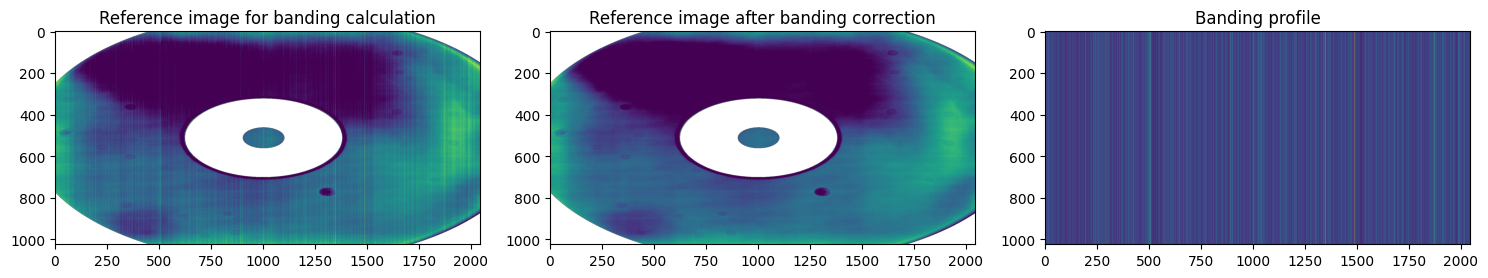

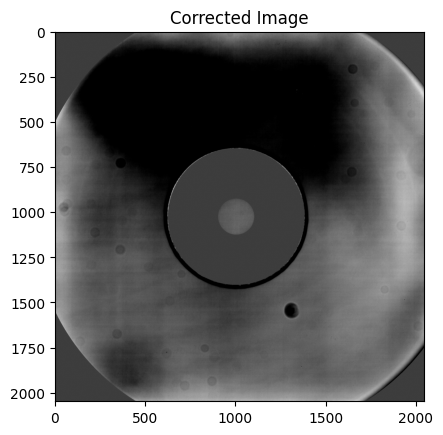

In [ ]:
from scipy.ndimage import median_filter

def split_rows(Im):
    """Split image into odd and even rows for further processing"""
    Im_odd  = Im[0::2,:]   # rows 0,2,4,...  (1,3,5,... in FITS standard)
    Im_even = Im[1::2,:]   # rows 1,3,5,...  (2,4,6,... in FITS standard)
    return Im_odd, Im_even

def correct_banding(img, saturation_mask = None, filter_2d=15, filter_1d=None, structures_threshold=None):
    """
    Corrects banding along the first dimension in an image using specified filtering and averaging methods.

    Parameters:
    -----------
    img : 2D numpy array
        The input image to be corrected.
    saturation_mask : 2D numpy array
        A boolean mask indicating saturated pixels in the image.
    filter_2d : int, optional
        Size of the median filter applied in 2D to remove large structures.
    filter_1d : int | False, optional
        Size of the median filter applied in 1D to remove outliers.
        Default is 4 * filter_2d.
        If False, no 1D filtering is applied and banding profile is computed for the entire line with np.nanmedian.
    structures_threshold : float, optional
        Threshold in standard deviation units to identify remaining structures.
        Default is 60 / filter_2d.

    Returns:
    --------
    corrected_img : 2D numpy array
        The banding-corrected image.

    """
    if saturation_mask is None:
        saturation_mask = np.zeros_like(img, dtype=bool)
    if structures_threshold is None:
        structures_threshold = 60 / filter_2d # threshold varies with filter size
    if filter_1d is None:
        filter_1d = filter_2d * 4  # make 1d filter size proportional to 2d filter size

    img_ref = np.float32(img.copy())
    img_ref[saturation_mask] = np.nan


    banding_vert = np.nanmedian(img_ref[512:,:], axis=0)  # cut off top half to avoid dark structures throwing off median

    banding_vert = banding_vert - median_filter(banding_vert, size=filter_2d)

    banding_vert = np.repeat(banding_vert[np.newaxis, :], img_ref.shape[0], axis=0)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].set_aspect('equal', adjustable='box')
    axes[1].set_aspect('equal', adjustable='box')
    axes[2].set_aspect('equal', adjustable='box')

    std_ref = np.nanstd(img_ref)
    mean_ref = np.nanmean(img_ref)
    
    axes[0].imshow(img_ref,vmin=mean_ref - 1*std_ref, vmax=mean_ref + 3*std_ref)
    axes[0].set_title("Reference image for banding calculation")
    
    axes[1].imshow((img_ref - banding_vert),vmin=mean_ref - 1*std_ref, vmax=mean_ref + 3*std_ref)
    axes[1].set_title("Reference image after banding correction")
    
    axes[2].imshow(banding_vert)
    axes[2].set_title("Banding profile")
    
    plt.tight_layout()
    plt.show()

    
    return img - banding_vert

def correct_banding_splitrows(img, saturation_mask,*args, **kwargs):
    img = img.copy()
    if saturation_mask is None:
        saturation_mask = np.zeros_like(img, dtype=bool)
    img[0::2, :] = correct_banding(img[0::2, :], saturation_mask=saturation_mask[0::2, :], *args, **kwargs) # top left
    img[1::2, :] = correct_banding(img[1::2, :], saturation_mask=saturation_mask[1::2, :], *args, **kwargs) # top right
    return img

saturation_mask = np.where(Im == 1.0, True, False)

Im = correct_banding_splitrows(Im, filter_2d=128, filter_1d=False, saturation_mask=saturation_mask)
Im[saturation_mask] = 1.0  # restore saturated pixels

banding_msg = "Line noise correction applied using median filtering."

std_ref = np.nanstd(Im)
mean_ref = np.nanmean(Im)
plt.imshow(Im, cmap='gray', vmin=mean_ref - 1*std_ref, vmax=mean_ref + 3*std_ref)
plt.title('Corrected Image')
plt.show()



In [64]:
### ************ updating keywords ************** ###
banding_msg = "Line noise correction applied using median filtering."
header.set("HISTORY", banding_msg)



### ************* write down the final Im into fits ****
hdu=fits.PrimaryHDU(Im,header=header)
filename=os.path.basename(filename)

file2write = os.path.join(outputdir,filename)
if os.path.isfile(file2write):
    print("% L2_MASTER. Output file "+file2write+" exists. Removing it")
    os.remove(file2write)
print("% L2_MASTER. Writing "+file2write)
hdu.writeto(file2write,checksum=True)



% L2_MASTER. Writing ./calibration-data/calibration_data_optimized/flatfield_WB.fits
